In [15]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from joblib import Parallel, delayed

# Preprocessing 

##### Data exploration : getting info from the data, dropping unusefull features

In [16]:
# Data reading
data = pd.read_csv('/Users/imanehaddouchi/Documents/M1MIA/HoML/water-potability/Water Quality Prediction.csv')

# Data information
print("Data information:")
data.info()

print("\nNumber of unique values per column:")
print(data.nunique())

# Distribution of target classes
print("\nTarget class distribution:\n", data['Target'].value_counts())

# Dropping useless features
features_to_drop = ['Index', 'Month', 'Day', 'Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            1019772 non-nul

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


#### NaN values location visualization 

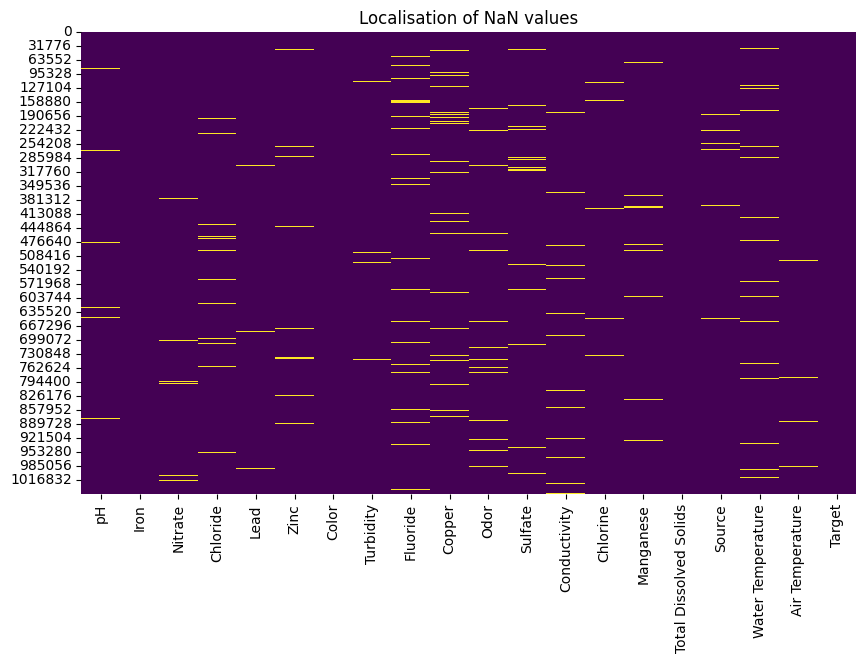

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation of NaN values")
plt.show()

#### NaN values 

In [18]:
# Calculating the percentage of NaN values
nan_percentage = data.isna().mean() * 100
print("\nPercentage of missing values before treatment:\n", nan_percentage)

# Dropping columns with more than 50% NaN values
data.drop(columns=nan_percentage[nan_percentage > 50].index, inplace=True)

# Identifying numerical and categorical columns
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Imputing missing values
num_imputer = SimpleImputer(strategy='mean')  # Mean imputation for numerical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode imputation for categorical columns

data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Checking for NaN values after imputation
print("\nMissing values after treatment:\n", data.isna().sum())



Percentage of missing values before treatment:
 pH                        1.929380
Iron                      0.666714
Nitrate                   1.782896
Chloride                  2.940562
Lead                      0.446701
Zinc                      2.639296
Color                     0.093556
Turbidity                 0.829125
Fluoride                  3.167918
Copper                    3.326610
Odor                      2.988055
Sulfate                   3.292564
Conductivity              2.746871
Chlorine                  0.969125
Manganese                 1.844313
Total Dissolved Solids    0.028420
Source                    1.481534
Water Temperature         2.831271
Air Temperature           0.505734
Target                    0.000000
dtype: float64

Missing values after treatment:
 pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turbid

In [19]:
# Encoding categorical columns
df_cat = data.select_dtypes(include=['object']).copy()
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = cat_encoder.fit_transform(df_cat)
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=cat_encoder.get_feature_names_out(df_cat.columns))

df_cat_encoded.index = data.index
data = pd.concat([data.drop(cat_cols, axis=1), df_cat_encoded], axis=1)

# Update cat_cols to reflect the newly encoded columns
cat_cols_encoded = df_cat_encoded.columns

# Visualizing categorical columns before and after encoding
print("\nCategorical columns before encoding:\n", df_cat.head())
print("\nCategorical columns after encoding:\n", df_cat_encoded.head())

# Descriptive statistics
print("\nDescriptive statistics for numerical data:\n", data.describe())

# Using the new encoded categorical columns
print("\nNumber of categories per categorical variable:\n", data[cat_cols_encoded].nunique())




Categorical columns before encoding:
             Color  Source
0       Colorless    Well
1    Faint Yellow    Lake
2    Light Yellow   River
3  Near Colorless  Ground
4    Light Yellow  Spring

Categorical columns after encoding:
    Color_Colorless  Color_Faint Yellow  Color_Light Yellow  \
0              1.0                 0.0                 0.0   
1              0.0                 1.0                 0.0   
2              0.0                 0.0                 1.0   
3              0.0                 0.0                 0.0   
4              0.0                 0.0                 1.0   

   Color_Near Colorless  Color_Yellow  Source_Aquifer  Source_Ground  \
0                   0.0           0.0             0.0            0.0   
1                   0.0           0.0             0.0            0.0   
2                   0.0           0.0             0.0            0.0   
3                   1.0           0.0             0.0            1.0   
4                   0.0           

#### Rate of potable and non potable water in our dataset


Target variable distribution:
Target
0.0    807841
1.0    240734
Name: count, dtype: int64


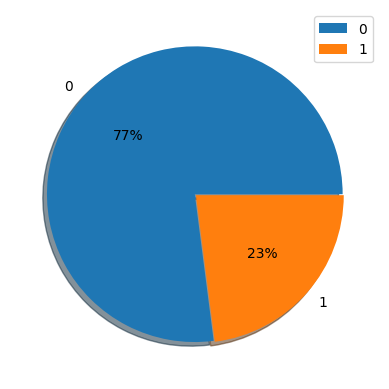

In [20]:
# Visualizing the distribution of the target variable
tar = data['Target'].value_counts()
print("\nTarget variable distribution:")
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()


# Training 

PCA


Statistiques descriptives des données numériques :
                  pH          Iron       Nitrate      Chloride           Lead  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   1.048575e+06   
mean   7.449869e+00  1.139646e-01  6.078584e+00  1.818660e+02   1.291635e-03   
std    8.396266e-01  4.418385e-01  3.103829e+00  6.479240e+01   3.023353e-02   
min    2.058008e+00  2.050000e-53  2.861727e-01  2.941350e+01   0.000000e+00   
25%    6.926029e+00  9.450000e-06  3.983113e+00  1.386358e+02  2.020000e-122   
50%    7.449869e+00  2.167424e-03  5.628327e+00  1.770015e+02   3.790000e-62   
75%    7.989743e+00  5.247472e-02  7.539901e+00  2.142176e+02   6.840000e-27   
max    1.289196e+01  1.574860e+01  7.307293e+01  1.430549e+03   3.503948e+00   

               Zinc     Turbidity      Fluoride        Copper          Odor  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   1.528928e+00  4.835915e-01  9.410137e-01  4.939443e-01  1.772

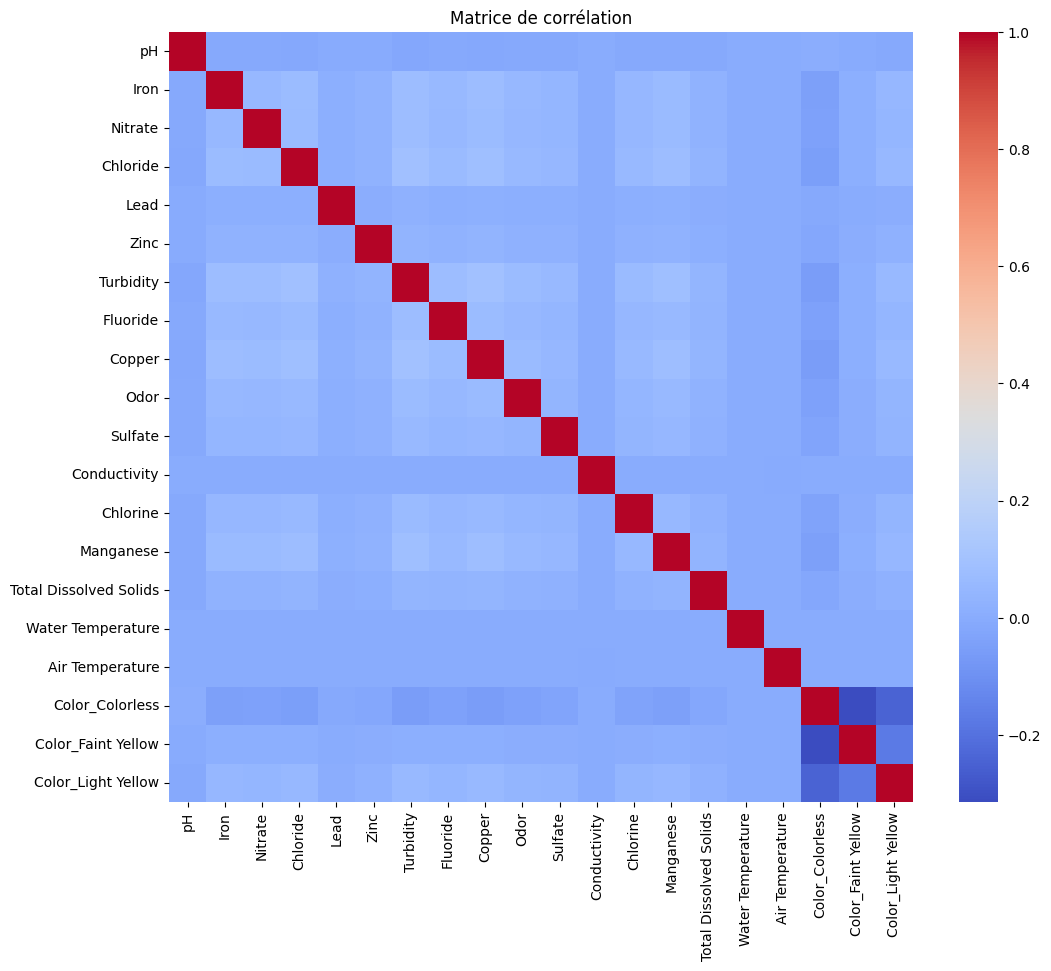

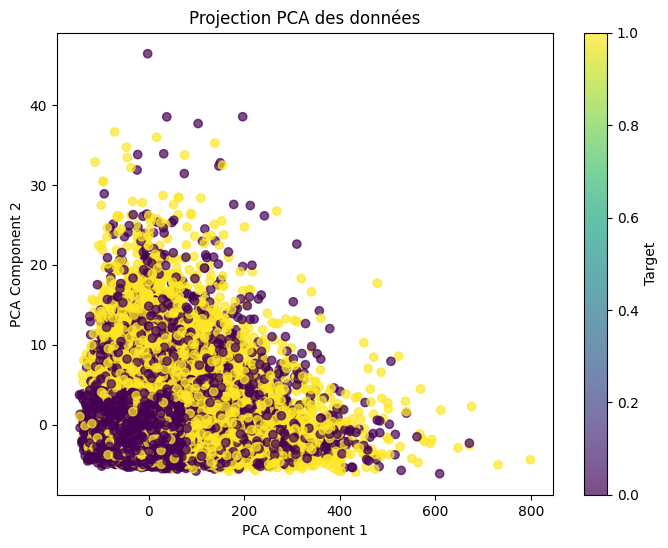

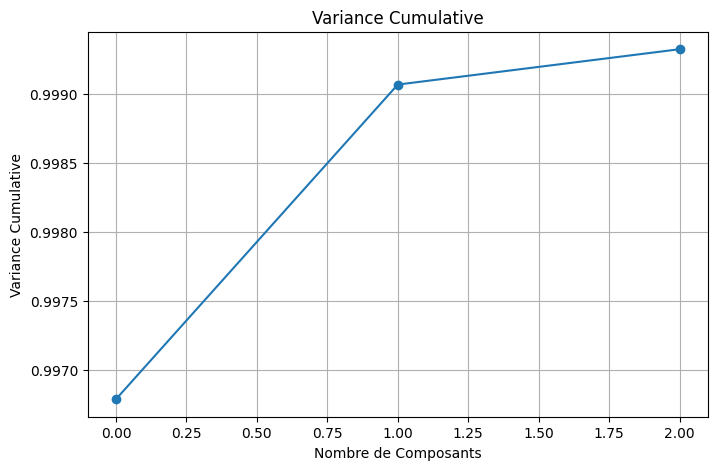

In [13]:
# Sélection de caractéristiques avant PCA
X_features = data.drop('Target', axis=1)
y_target = data['Target']

# Statistiques descriptives
print("\nStatistiques descriptives des données numériques :\n", data.describe())

# Utilisation des nouvelles colonnes encodées (en supposant qu'elles existent déjà)
print("\nNombre de catégories par variable catégorielle :\n", data[cat_cols_encoded].nunique())

# Sélection des caractéristiques (en sélectionnant les 10 meilleures caractéristiques)
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Sélectionne les 10 meilleures caractéristiques
X_selected = selector.fit_transform(X_features, y_target)
selected_features = X_features.columns[selector.get_support()]

# Vérification des colonnes sélectionnées
print("\nColonnes sélectionnées :\n", selected_features)


# Visualisation de la matrice de corrélation (en limitant le nombre de variables)
plt.figure(figsize=(12, 10))
sns.heatmap(X_features.iloc[:, :20].corr(), cmap="coolwarm", annot=False, fmt=".2f")  # Limité à 20 premières colonnes
plt.title("Matrice de corrélation")
plt.show()

# Conversion de X_selected en DataFrame Pandas pour utiliser .sample()
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
sample_data = X_selected_df.sample(frac=0.1, random_state=42)  # Utilisation de 10% des données

# PCA : Exploration graphique avec un échantillon pour accélérer
pca = PCA(n_components=2, svd_solver='randomized')  # Utilisation de la méthode randomisée pour accélérer
X_pca = pca.fit_transform(sample_data)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_target.loc[sample_data.index], cmap='viridis', alpha=0.7)  # Assurer l'alignement des cibles
plt.colorbar(label='Target')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Projection PCA des données')
plt.show()

# Analyse cumulative de la variance expliquée (en utilisant seulement 3 composants pour accélérer)
pca_full = PCA(n_components=3, svd_solver='randomized')  # Réduit à 3 composants
X_pca_full = pca_full.fit_transform(X_selected)
explained_variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title("Variance Cumulative")
plt.xlabel("Nombre de Composants")
plt.ylabel("Variance Cumulative")
plt.grid()
plt.show()

In [ ]:
# --- Validation Croisée (Cross-Validation) --- 

# Création d'un modèle de classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Validation croisée : utilisation de 5 plis 
cv_scores = cross_val_score(clf, X_selected, y_target, cv=5)  # cv=5 : 5 plis

# Affichage des résultats de la validation croisée
print("\nScores de validation croisée (5 plis) :", cv_scores)
print("Score moyen de la validation croisée :", np.mean(cv_scores))

KeyboardInterrupt: 

In [10]:
# Prétraitement pour modèles
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_target, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', 'passthrough', df_cat_encoded.columns)
    ]
)

### Train different models

In [11]:
# Liste des modèles
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

In [19]:
# Entraînement parallèle des modèles
def train_and_evaluate(model_name, model):
    print(f"\nEntraînement du modèle : {model_name}")
    
    # Si X_train et X_test sont des objets memmap, les convertir en DataFrame
    if isinstance(X_train, np.memmap):
        X_train_df = pd.DataFrame(X_train, columns=selected_features)
    else:
        X_train_df = pd.DataFrame(X_train, columns=selected_features)

    if isinstance(X_test, np.memmap):
        X_test_df = pd.DataFrame(X_test, columns=selected_features)
    else:
        X_test_df = pd.DataFrame(X_test, columns=selected_features)
    
    # Vérification de la présence des colonnes dans X_train et X_test
    print("Colonnes de X_train:", X_train_df.columns)
    print("Colonnes de X_test:", X_test_df.columns)
    
    # Vérifiez si 'Iron' est dans selected_features
    if 'Iron' not in selected_features:
        print("La colonne 'Iron' n'est pas dans selected_features.")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Entraînement et prédiction
    pipeline.fit(X_train_df, y_train)  # Utilisez X_train_df et X_test_df
    y_pred = pipeline.predict(X_test_df)
    y_prob = pipeline.predict_proba(X_test_df)[:, 1] if hasattr(pipeline, "predict_proba") else None
    
    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cv_scores = cross_val_score(pipeline, X_train_df, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

    # Courbe ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.title(f"Courbe ROC - {model_name}")
        plt.xlabel("Taux de Faux Positifs")
        plt.ylabel("Taux de Vrais Positifs")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    
    return {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1,
        'CV Accuracy': cv_scores
    }

# Entraînement parallèle des modèles
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(name, model) for name, model in models.items())

# Résultats
results_df = pd.DataFrame(results, index=models.keys())
print("\nComparaison des modèles :\n", results_df)


Entraînement du modèle : Naive Bayes
Colonnes de X_train: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
Colonnes de X_test: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
La colonne 'Iron' n'est pas dans selected_features.

Entraînement du modèle : Logistic Regression
Colonnes de X_train: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
Colonnes de X_test: Index(['pH', 'Nitrate', 'Chloride', 'Turbidity', 'Copper', 'Odor', 'Chlorine',
       'Manganese', 'Color_Colorless', 'Color_Near Colorless'],
      dtype='object')
La colonne 'Iron' n'est pas dans selected_features.

Entraînement du modèle : Decision Tree


ValueError: A given column is not a column of the dataframe

In [ ]:
# Optimisation des hyperparamètres avec GridSearchCV
param_grids = {
    'Random Forest': {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]},
    'SVM': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

def perform_grid_search(model_name, model, param_grid):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Visualisation de la performance de GridSearch
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(8, 5))
    plt.plot(results['param_model__C'], results['mean_test_score'], label='Test Score')
    plt.plot(results['param_model__C'], results['mean_train_score'], label='Train Score')
    plt.title(f"Optimisation des hyperparamètres pour {model_name}")
    plt.xlabel("Paramètre")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
    return model_name, grid_search.best_params_

optimized_results = Parallel(n_jobs=-1)(
    delayed(perform_grid_search)(model_name, models[model_name], param_grids[model_name])
    for model_name in param_grids.keys()
)

# Conversion des résultats en dictionnaire
optimized_results = dict(optimized_results)
print("\nMeilleurs hyperparamètres :\n", optimized_results)